In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import segmentation_models_pytorch as smp  
warnings.filterwarnings('ignore')

c:\Users\sua10\project\dl\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dataset import PneumothoraxDataset, get_train_transforms, get_val_transforms
from utils import predict_with_tiles, dice_coefficient, iou_score
#from models.unet import UNet
from dataset import build_file_paths_dict

In [4]:
class Config:
    # Paths
    dicom_path = Path('./pneumothorax_data/dicom-images-train')
    rle_path = Path('./pneumothorax_data/train-rle.csv')
    save_dir = Path('./results')
    
    # Model
    model_name = 'unet' #모델명 여기서 수정
    in_channels = 3
    n_classes = 1
    
    # Training
    batch_size = 2 #수정
    num_epochs = 1 #수정
    learning_rate = 1e-4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Augmentation
    use_mirroring = False #수정
    pad_size = 0#92
    
    use_tile_strategy = True
    tile_size = 128 #512
    tile_overlap = 92

config = Config()
config.save_dir.mkdir(exist_ok=True)

In [5]:
file_paths_dict = build_file_paths_dict(config.dicom_path)

전체 DICOM 파일 수: 10712


인덱싱: 100%|██████████| 10712/10712 [00:00<00:00, 1274845.63it/s]


In [6]:
train_rle = pd.read_csv(config.rle_path)

image_labels = []
for img_id in train_rle['ImageId'].unique():
    rle_value = train_rle[train_rle['ImageId'] == img_id][' EncodedPixels'].values[0]
    has_pneumothorax = 1 if (rle_value != ' -1' and pd.notna(rle_value)) else 0
    image_labels.append((img_id, has_pneumothorax))

df_labels = pd.DataFrame(image_labels, columns=['ImageId', 'has_pneumothorax'])

from sklearn.model_selection import train_test_split

train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

train_ids, temp_ids = train_test_split(
    df_labels['ImageId'].values,
    test_size=(val_ratio + test_ratio),
    stratify=df_labels['has_pneumothorax'].values,
    random_state=42
)

temp_labels = df_labels[df_labels['ImageId'].isin(temp_ids)]['has_pneumothorax'].values
val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=test_ratio/(val_ratio + test_ratio),
    stratify=temp_labels,
    random_state=42
)

train_ids = train_ids[:2]
val_ids = val_ids[:2]
test_ids = test_ids[:2]

print(f"Total images: {len(df_labels)}")
print(f"Train: {len(train_ids):5d} ({len(train_ids)/len(df_labels)*100:.1f}%)")
print(f"Val:   {len(val_ids):5d} ({len(val_ids)/len(df_labels)*100:.1f}%)")
print(f"Test:  {len(test_ids):5d} ({len(test_ids)/len(df_labels)*100:.1f}%)")

def check_distribution(ids, name):
    subset_df = df_labels[df_labels['ImageId'].isin(ids)]
    positive = subset_df['has_pneumothorax'].sum()
    negative = len(subset_df) - positive
    print(f"\n{name}:")
    print(f"  양성: {positive:5d} ({positive/len(subset_df)*100:.1f}%)")
    print(f"  음성: {negative:5d} ({negative/len(subset_df)*100:.1f}%)")

check_distribution(train_ids, "Train")
check_distribution(val_ids, "Validation")
check_distribution(test_ids, "Test")

Total images: 10675
Train:     2 (0.0%)
Val:       2 (0.0%)
Test:      2 (0.0%)

Train:
  양성:     0 (0.0%)
  음성:     2 (100.0%)

Validation:
  양성:     1 (50.0%)
  음성:     1 (50.0%)

Test:
  양성:     2 (100.0%)
  음성:     0 (0.0%)


In [7]:
_use_mirr_train = True
_pad_train = (config.pad_size if _use_mirr_train else 0)

train_dataset = PneumothoraxDataset(
    image_ids=train_ids,
    train_rle=train_rle,
    file_paths_dict=file_paths_dict,
    transform=get_train_transforms(),
    use_mirroring=_use_mirr_train,
    pad_size=_pad_train
)

val_dataset = PneumothoraxDataset(
    image_ids=val_ids,
    train_rle=train_rle,
    file_paths_dict=file_paths_dict,
    transform=get_val_transforms(),
    use_mirroring=False,
    pad_size=0
)

test_dataset = PneumothoraxDataset(
    image_ids=test_ids,
    train_rle=train_rle,
    file_paths_dict=file_paths_dict,
    transform=get_val_transforms(),
    use_mirroring=False,
    pad_size=0
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

사용 가능한 이미지: 2개

사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



In [8]:
print(f"모델 명 : {config.model_name}")
#model = UNet(in_channels=config.in_channels, n_classes=config.n_classes)
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=config.in_channels,
    classes=config.n_classes,
    activation=None
)
model = model.to(config.device)

criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.99, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)


모델 명 : unet


In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    with tqdm(loader, desc="Training") as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Metrics
            with torch.no_grad():
                preds = torch.sigmoid(outputs)
                dice = dice_coefficient(preds > 0.5, masks)
            
            running_loss += loss.item()
            running_dice += dice
            
            pbar.set_postfix({'loss': loss.item(), 'dice': dice})
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    
    return epoch_loss, epoch_dice

In [10]:
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    with torch.no_grad():
        with tqdm(loader, desc="Validation") as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                preds = torch.sigmoid(outputs)
                dice = dice_coefficient(preds > 0.5, masks)
                iou = iou_score(preds > 0.5, masks)
                
                running_loss += loss.item()
                running_dice += dice
                running_iou += iou
                
                pbar.set_postfix({'loss': loss.item(), 'dice': dice, 'iou': iou})
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

In [ ]:
# ===== Helper builders for tuning =====
import copy, time, math, random
from pathlib import Path

# # (1) 모델 빌더: 현재 UNet 시그니처 유지
# def build_model(cfg):
#     m = UNet(in_channels=cfg.in_channels, n_classes=cfg.n_classes)
#     return m.to(cfg.device)
def build_model(cfg):
    m = smp.Unet(
        encoder_name='resnet34',        # 백본 선택
        encoder_weights='imagenet',     # pretrained weights
        in_channels=cfg.in_channels,    # 3
        classes=cfg.n_classes,          # 1
        activation=None                 # logits 출력 (BCEWithLogitsLoss 사용)
    )
    return m.to(cfg.device)

# (2) 데이터로더 빌더: batch_size 등 cfg 반영
def build_dataloaders(cfg):
    _use_mirr_train = True
    _pad_train = (cfg.pad_size if _use_mirr_train else 0)

    tr_ds = PneumothoraxDataset(
        image_ids=train_ids,
        train_rle=train_rle,
        file_paths_dict=file_paths_dict,
        transform=get_train_transforms(),
        use_mirroring=_use_mirr_train,
        pad_size=_pad_train
    )
    va_ds = PneumothoraxDataset(
        image_ids=val_ids,
        train_rle=train_rle,
        file_paths_dict=file_paths_dict,
        transform=get_val_transforms(),
        use_mirroring=False,
        pad_size=0
    )

    tr_loader = DataLoader(tr_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    va_loader = DataLoader(va_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    return tr_loader, va_loader

# (3) 손실 빌더: BCE+Dice / Focal+Dice 지원
def build_loss(loss_type="bce_dice", pos_weight=1.0):
    import torch.nn as nn

    class DiceLoss(nn.Module):
        def __init__(self, eps=1e-6):
            super().__init__()
            self.eps = eps
        def forward(self, logits, targets):
            probs = torch.sigmoid(logits)
            dims = (1,2,3)
            inter = (probs*targets).sum(dims)
            denom = probs.sum(dims) + targets.sum(dims) + self.eps
            dice = (2*inter + self.eps) / denom
            return 1 - dice.mean()

    if loss_type == "bce_dice":
        bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=config.device))
        return lambda pred, tgt: 0.5*bce(pred, tgt) + 0.5*DiceLoss()(pred, tgt)
    elif loss_type == "focal_dice":
        class FocalLoss(nn.Module):
            def __init__(self, alpha=0.25, gamma=2.0):
                super().__init__()
                self.alpha, self.gamma = alpha, gamma
            def forward(self, logits, targets):
                p  = torch.sigmoid(logits)
                pt = p*targets + (1-p)*(1-targets)
                w  = self.alpha*targets + (1-self.alpha)*(1-targets)
                return ((-w*(1-pt).pow(self.gamma)*pt.clamp_min(1e-6).log())).mean()
        fl = FocalLoss()
        return lambda pred, tgt: 0.5*fl(pred, tgt) + 0.5*DiceLoss()(pred, tgt)

# (4) 옵티마/스케줄러
def build_optimizer(cfg, model):
    # SGD 기반 튜닝이므로 lr/momentum/weight_decay 반영
    return optim.SGD(model.parameters(), lr=cfg.learning_rate,
                     momentum=getattr(cfg, "momentum", 0.9),
                     weight_decay=getattr(cfg, "weight_decay", 0.0))

def build_scheduler(cfg, optimizer):
    st = getattr(cfg, "scheduler", "plateau")
    if st == "cosine":
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.num_epochs)
    elif st == "step":
        return optim.lr_scheduler.StepLR(optimizer, step_size=max(2, cfg.num_epochs//2), gamma=0.5)
    elif st == "plateau":
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=False)
    else:
        return None

# (5) 단일 실험 실행
def run_experiment(base_cfg, hp, max_epochs=None, verbose=True):
    cfg = copy.deepcopy(base_cfg)
    # HP 반영
    cfg.learning_rate = hp["lr"]
    cfg.momentum      = hp["momentum"]
    cfg.weight_decay  = hp["weight_decay"]
    cfg.batch_size    = hp["batch_size"]
    cfg.loss_type     = hp["loss_type"]
    cfg.pos_weight    = hp["pos_weight"]
    cfg.scheduler     = hp["scheduler"]
    if max_epochs is not None:
        cfg.num_epochs = max_epochs

    # 빌드
    model = build_model(cfg)
    criterion = build_loss(cfg.loss_type, cfg.pos_weight)
    optimizer = build_optimizer(cfg, model)
    scheduler = build_scheduler(cfg, optimizer)
    train_loader, val_loader = build_dataloaders(cfg)

    best_dice = -1.0
    hist = {"train_loss":[], "val_loss":[], "train_dice":[], "val_dice":[], "val_iou":[]}

    for ep in range(cfg.num_epochs):
        tr_loss, tr_dice = train_epoch(model, train_loader, criterion, optimizer, cfg.device)
        val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, cfg.device)
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        elif scheduler is not None:
            scheduler.step()

        hist["train_loss"].append(tr_loss); hist["val_loss"].append(val_loss)
        hist["train_dice"].append(tr_dice); hist["val_dice"].append(val_dice); hist["val_iou"].append(val_iou)

        if val_dice > best_dice:
            best_dice = val_dice
            Path(cfg.save_dir).mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), cfg.save_dir / f"best_{cfg.model_name}_TUNE.pth")

        if verbose:
            print(f"[Epoch {ep+1}/{cfg.num_epochs}] tr_loss={tr_loss:.4f} val_loss={val_loss:.4f} dice={val_dice:.4f} iou={val_iou:.4f}")

    return best_dice, hist, cfg

In [12]:
# ===== Random Search for SGD =====
random.seed(42); torch.manual_seed(42)

# 12GB 기준 안전/유효 범위
SEARCH_SPACE = {
    "lr":           [3e-3, 1e-2, 2e-2, 3e-2],
    "momentum":     [0.9, 0.95, 0.99],
    "weight_decay": [0.0, 1e-4, 1e-3],
    "batch_size":   [2, 4],                     # 768 해상도면 4 추천(지금은 1024 원본이라 2~4)
    "loss_type":    ["bce_dice", "focal_dice"],
    "pos_weight":   [1.0, 2.0, 3.0],            # focal일 땐 무시
    "scheduler":    ["plateau", "cosine", "step", "none"],
}

def sample_hp():
    hp = {k: random.choice(v) for k, v in SEARCH_SPACE.items()}
    if hp["loss_type"] == "focal_dice":
        hp["pos_weight"] = 1.0
    return hp

TRIALS = 6
EPOCHS_PER_TRIAL = 3

results = []
for t in range(TRIALS):
    hp = sample_hp()
    print(f"\n=== Trial {t} | hp={hp}")
    score, hist, used_cfg = run_experiment(config, hp, max_epochs=EPOCHS_PER_TRIAL, verbose=False)
    print(f"→ Dice={score:.4f}")
    results.append((score, hp))

results.sort(key=lambda x: -x[0])
print("\n=== TOP-3 ===")
for i, (s, h) in enumerate(results[:3], 1):
    print(f"{i}. Dice={s:.4f} | hp={h}")

best_hp = results[0][1]
best_hp


=== Trial 0 | hp={'lr': 0.003, 'momentum': 0.9, 'weight_decay': 0.001, 'batch_size': 4, 'loss_type': 'bce_dice', 'pos_weight': 1.0, 'scheduler': 'cosine'}
사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



Validation: 100%|██████████| 1/1 [00:05<00:00,  5.78s/it, loss=0.96, dice=0.00605, iou=0.00303]


→ Dice=0.0061

=== Trial 1 | hp={'lr': 0.003, 'momentum': 0.99, 'weight_decay': 0.001, 'batch_size': 2, 'loss_type': 'focal_dice', 'pos_weight': 1.0, 'scheduler': 'plateau'}
사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



Validation: 100%|██████████| 1/1 [00:05<00:00,  5.90s/it, loss=0.529, dice=1.86e-11, iou=1.86e-11]


→ Dice=0.0000

=== Trial 2 | hp={'lr': 0.003, 'momentum': 0.9, 'weight_decay': 0.0, 'batch_size': 2, 'loss_type': 'bce_dice', 'pos_weight': 3.0, 'scheduler': 'none'}
사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



Validation: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it, loss=0.85, dice=0.0115, iou=0.00578]


→ Dice=0.0115

=== Trial 3 | hp={'lr': 0.01, 'momentum': 0.95, 'weight_decay': 0.001, 'batch_size': 4, 'loss_type': 'bce_dice', 'pos_weight': 1.0, 'scheduler': 'none'}
사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



Validation: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it, loss=0.806, dice=0.000122, iou=6.09e-5]


→ Dice=0.0001

=== Trial 4 | hp={'lr': 0.02, 'momentum': 0.95, 'weight_decay': 0.0, 'batch_size': 2, 'loss_type': 'focal_dice', 'pos_weight': 1.0, 'scheduler': 'plateau'}
사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



Validation: 100%|██████████| 1/1 [00:06<00:00,  6.60s/it, loss=0.693, dice=0.00621, iou=0.00311]


→ Dice=0.0062

=== Trial 5 | hp={'lr': 0.03, 'momentum': 0.9, 'weight_decay': 0.0001, 'batch_size': 4, 'loss_type': 'focal_dice', 'pos_weight': 1.0, 'scheduler': 'none'}
사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



Validation: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it, loss=0.535, dice=4.08e-12, iou=4.08e-12]

→ Dice=0.0000

=== TOP-3 ===
1. Dice=0.0115 | hp={'lr': 0.003, 'momentum': 0.9, 'weight_decay': 0.0, 'batch_size': 2, 'loss_type': 'bce_dice', 'pos_weight': 3.0, 'scheduler': 'none'}
2. Dice=0.0062 | hp={'lr': 0.02, 'momentum': 0.95, 'weight_decay': 0.0, 'batch_size': 2, 'loss_type': 'focal_dice', 'pos_weight': 1.0, 'scheduler': 'plateau'}
3. Dice=0.0061 | hp={'lr': 0.003, 'momentum': 0.9, 'weight_decay': 0.001, 'batch_size': 4, 'loss_type': 'bce_dice', 'pos_weight': 1.0, 'scheduler': 'cosine'}


{'lr': 0.003,
 'momentum': 0.9,
 'weight_decay': 0.0,
 'batch_size': 2,
 'loss_type': 'bce_dice',
 'pos_weight': 3.0,
 'scheduler': 'none'}

사용 가능한 이미지: 2개

사용 가능한 이미지: 2개



Validation: 100%|██████████| 1/1 [00:06<00:00,  6.64s/it, loss=0.861, dice=0.00689, iou=0.00346]


[E1/20] tr_loss=0.9923 val_loss=0.8607 dice=0.0069 iou=0.0035


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.85s/it, loss=0.859, dice=0.00319, iou=0.0016]


[E2/20] tr_loss=0.9954 val_loss=0.8593 dice=0.0032 iou=0.0016


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it, loss=0.851, dice=9.82e-13, iou=9.82e-13]


[E3/20] tr_loss=0.9699 val_loss=0.8514 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it, loss=0.845, dice=0.000332, iou=0.000166]


[E4/20] tr_loss=0.9690 val_loss=0.8451 dice=0.0003 iou=0.0002


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.02s/it, loss=0.854, dice=0.00856, iou=0.0043]


[E5/20] tr_loss=0.9373 val_loss=0.8542 dice=0.0086 iou=0.0043


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.17s/it, loss=0.863, dice=0.00795, iou=0.00399]


[E6/20] tr_loss=0.9327 val_loss=0.8629 dice=0.0079 iou=0.0040


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it, loss=0.842, dice=0.000989, iou=0.000495]


[E7/20] tr_loss=0.9077 val_loss=0.8416 dice=0.0010 iou=0.0005


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it, loss=0.845, dice=0.00366, iou=0.00184]


[E8/20] tr_loss=0.8858 val_loss=0.8455 dice=0.0037 iou=0.0018


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it, loss=0.823, dice=2.17e-12, iou=2.17e-12]


[E9/20] tr_loss=0.8536 val_loss=0.8232 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.02s/it, loss=0.816, dice=0.00754, iou=0.00379]


[E10/20] tr_loss=0.8345 val_loss=0.8163 dice=0.0075 iou=0.0038


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it, loss=0.81, dice=0.00128, iou=0.000641]


[E11/20] tr_loss=0.8128 val_loss=0.8097 dice=0.0013 iou=0.0006


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.48s/it, loss=0.792, dice=0.00131, iou=0.000658]


[E12/20] tr_loss=0.7938 val_loss=0.7919 dice=0.0013 iou=0.0007


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.00s/it, loss=0.779, dice=6.54e-12, iou=6.54e-12]


[E13/20] tr_loss=0.7760 val_loss=0.7789 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it, loss=0.762, dice=1.54e-11, iou=1.54e-11]


[E14/20] tr_loss=0.7565 val_loss=0.7615 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.14s/it, loss=0.736, dice=2.16e-11, iou=2.16e-11]


[E15/20] tr_loss=0.7397 val_loss=0.7355 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it, loss=0.721, dice=3.25e-11, iou=3.25e-11]


[E16/20] tr_loss=0.7308 val_loss=0.7206 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it, loss=0.723, dice=3.76e-11, iou=3.76e-11]


[E17/20] tr_loss=0.7118 val_loss=0.7233 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it, loss=0.689, dice=4.05e-11, iou=4.05e-11]


[E18/20] tr_loss=0.7056 val_loss=0.6887 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it, loss=0.682, dice=6.61e-11, iou=6.61e-11]


[E19/20] tr_loss=0.6854 val_loss=0.6825 dice=0.0000 iou=0.0000


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.97s/it, loss=0.702, dice=7.16e-11, iou=7.16e-11]


[E20/20] tr_loss=0.6755 val_loss=0.7019 dice=0.0000 iou=0.0000

[FINAL] best Dice=0.0086


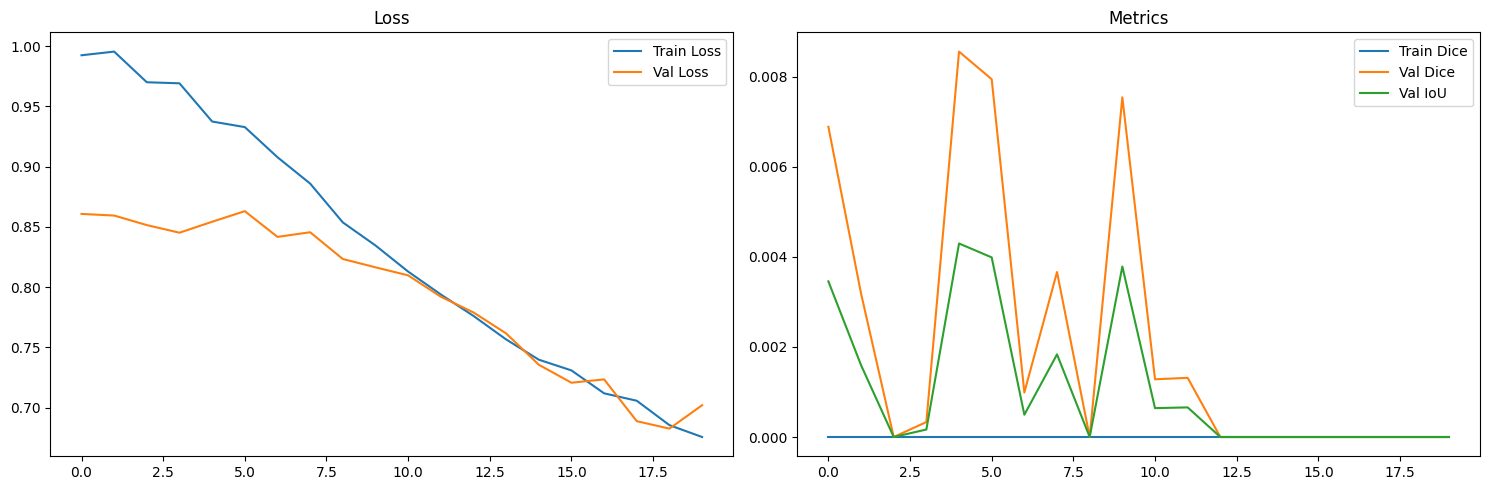

In [13]:
# ===== Final training with best hyperparams =====
# 튜닝 결과(best_hp)를 사용해 에폭만 늘려 본 학습
FINAL_EPOCHS = 20

final_score, final_hist, final_cfg = run_experiment(config, best_hp, max_epochs=FINAL_EPOCHS, verbose=True)
print(f"\n[FINAL] best Dice={final_score:.4f}")

# (선택) 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(final_hist["train_loss"], label="Train Loss")
axes[0].plot(final_hist["val_loss"], label="Val Loss")
axes[0].set_title("Loss"); axes[0].legend()

axes[1].plot(final_hist["train_dice"], label="Train Dice")
axes[1].plot(final_hist["val_dice"], label="Val Dice")
axes[1].plot(final_hist["val_iou"],  label="Val IoU")
axes[1].set_title("Metrics"); axes[1].legend()
plt.tight_layout()
plt.show()

In [14]:
# best_dice = 0.0
# history = {
#     'train_loss': [], 'train_dice': [],
#     'val_loss': [], 'val_dice': [], 'val_iou': []
# }

# for epoch in range(config.num_epochs):
#     print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    
#     train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, config.device)
#     val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, config.device)
    
#     scheduler.step(val_loss)
    
#     history['train_loss'].append(train_loss)
#     history['train_dice'].append(train_dice)
#     history['val_loss'].append(val_loss)
#     history['val_dice'].append(val_dice)
#     history['val_iou'].append(val_iou)
    
#     print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
#     print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")
    
#     if val_dice > best_dice:
#         best_dice = val_dice
#         torch.save(model.state_dict(), config.save_dir / f'best_{config.model_name}.pth')
#         print(f"best model saved. (Dice: {best_dice:.4f})")

In [15]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# axes[0].plot(history['train_loss'], label='Train Loss')
# axes[0].plot(history['val_loss'], label='Val Loss')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Loss')
# axes[0].legend()
# axes[0].set_title('Loss')

# axes[1].plot(history['train_dice'], label='Train Dice')
# axes[1].plot(history['val_dice'], label='Val Dice')
# axes[1].plot(history['val_iou'], label='Val IoU')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Score')
# axes[1].legend()
# axes[1].set_title('Metrics')

# plt.tight_layout()
# plt.savefig(config.save_dir / f'{config.model_name}_history.png')
# plt.show()

In [16]:
# model.load_state_dict(torch.load(config.save_dir / f'best_{config.model_name}.pth'))
# model.eval()

# test_samples = val_ids[:5]  # 5개 샘플만 테스트

# for img_id in test_samples:
#     # Load image
#     file_path = val_dataset.file_paths[img_id]
#     import pydicom
#     dcm = pydicom.dcmread(file_path)
#     image = dcm.pixel_array
    
#     if image.max() > 0:
#         image = image.astype(np.float32) / image.max()
#     else:
#         image = image.astype(np.float32)
    
#     image = np.stack([image, image, image], axis=-1)
    
#     # Predict
#     if config.use_tile_strategy:
#         prediction = predict_with_tiles(
#             model=model,
#             image=image,
#             tile_size=config.tile_size,
#             overlap=config.tile_overlap,
#             device=config.device
#         )
#     else:
#         # Simple inference
#         image_norm = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
#         image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).unsqueeze(0).float().to(config.device)
        
#         with torch.no_grad():
#             output = model(image_tensor)
#             prediction = torch.sigmoid(output).cpu().numpy()[0, 0]
    
#     # Threshold
#     binary_pred = (prediction > 0.5).astype(np.uint8)
    
#     # Load ground truth
#     rle = train_rle[train_rle['ImageId'] == img_id][' EncodedPixels'].values[0]
#     from dataset import rle_decode
    
#     if rle == '-1' or pd.isna(rle):
#         gt_mask = np.zeros((1024, 1024), dtype=np.uint8)
#     else:
#         gt_mask = rle_decode(rle, 1024, 1024)
    
#     # Visualize
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
#     axes[0].imshow(image[:, :, 0], cmap='gray')
#     axes[0].set_title('Original Image')
#     axes[0].axis('off')
    
#     axes[1].imshow(gt_mask, cmap='gray')
#     axes[1].set_title('Ground Truth')
#     axes[1].axis('off')
    
#     axes[2].imshow(binary_pred, cmap='gray')
#     axes[2].set_title('Prediction')
#     axes[2].axis('off')
    
#     plt.tight_layout()
#     plt.savefig(config.save_dir / f'prediction_{img_id}.png')
#     plt.close()

# print(f"결과 파일 : {config.save_dir}")

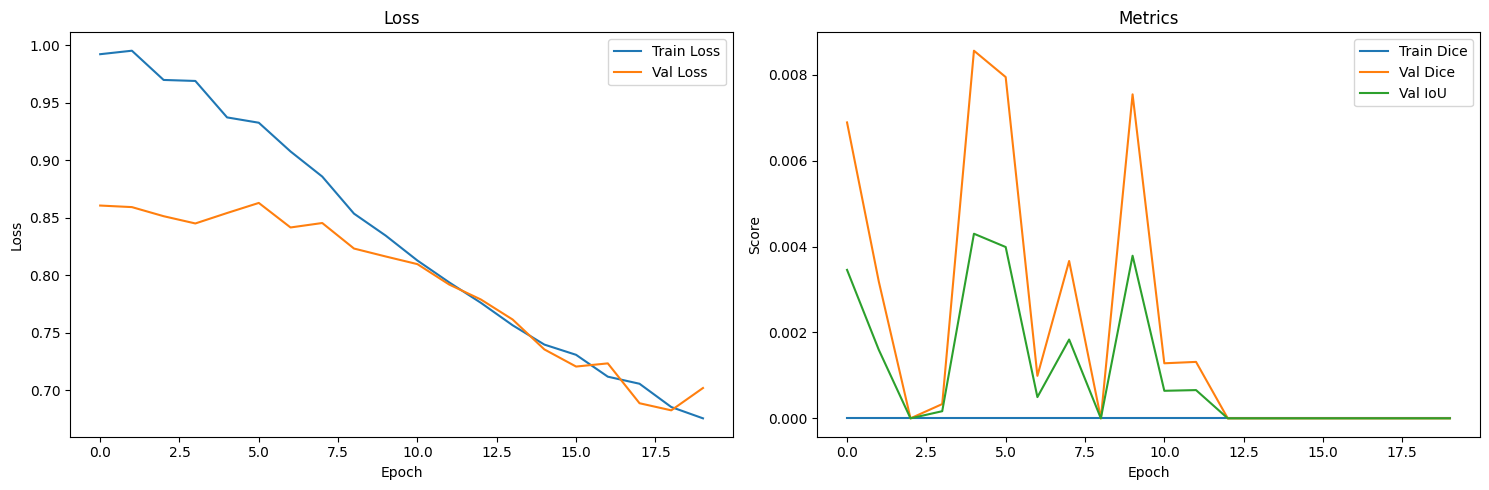

In [17]:
# (history -> final_hist 로 교체)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(final_hist['train_loss'], label='Train Loss')
axes[0].plot(final_hist['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].set_title('Loss')

axes[1].plot(final_hist['train_dice'], label='Train Dice')
axes[1].plot(final_hist['val_dice'], label='Val Dice')
axes[1].plot(final_hist['val_iou'],  label='Val IoU')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Score'); axes[1].legend(); axes[1].set_title('Metrics')

plt.tight_layout()
plt.savefig(config.save_dir / f'{config.model_name}_history_final.png')
plt.show()

In [18]:
print("\n테스트 추론 중...")
model.load_state_dict(torch.load(config.save_dir / f'best_{config.model_name}_TUNE.pth'))
model.eval()

# 테스트 샘플 예측 (validation set에서 샘플링)
test_samples = val_ids[:5]  # 5개 샘플만 테스트

for img_id in test_samples:
    # Load image
    file_path = val_dataset.file_paths[img_id]
    import pydicom
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if image.max() > 0:
        image = image.astype(np.float32) / image.max()
    else:
        image = image.astype(np.float32)
    
    image = np.stack([image, image, image], axis=-1)
    
    # Predict
    if config.use_tile_strategy:
        prediction = predict_with_tiles(
            model=model,
            image=image,
            tile_size=config.tile_size,
            overlap=config.tile_overlap,
            device=config.device
        )
    else:
        # Simple inference
        image_norm = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).unsqueeze(0).float().to(config.device)
        
        with torch.no_grad():
            output = model(image_tensor)
            prediction = torch.sigmoid(output).cpu().numpy()[0, 0]
    
    # Threshold
    binary_pred = (prediction > 0.5).astype(np.uint8)
    
    # Load ground truth
    rle = train_rle[train_rle['ImageId'] == img_id][' EncodedPixels'].values[0]
    from dataset import rle_decode
    
    if rle == '-1' or pd.isna(rle):
        gt_mask = np.zeros((1024, 1024), dtype=np.uint8)
    else:
        gt_mask = rle_decode(rle, 1024, 1024)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image[:, :, 0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(gt_mask, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    axes[2].imshow(binary_pred, cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(config.save_dir / f'prediction_{img_id}.png')
    plt.close()

print(f"\n완료! 결과는 {config.save_dir}에 저장되었습니다.")


테스트 추론 중...


Predicting tiles: 0it [00:00, ?it/s]
Predicting tiles: 0it [00:00, ?it/s]



완료! 결과는 results에 저장되었습니다.


In [ ]:
model.load_state_dict(torch.load(config.save_dir / f'best_{config.model_name}_TUNE.pth'))
model.eval()

test_loss, test_dice, test_iou = validate_epoch(model, test_loader, criterion, config.device)

print("TEST RESULTS :")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test IoU:  {test_iou:.4f}")
print("="*70)

# Save results
test_results = {
    'test_loss': test_loss,
    'test_dice': test_dice,
    'test_iou': test_iou,
}

import json
with open(config.save_dir / 'test_results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

print(f"\nTest results saved - {config.save_dir / 'test_results.json'}")

Validation: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it, loss=0.708, dice=0.0298, iou=0.0151]

TEST RESULTS :
Test Loss: 0.7081
Test Dice: 0.0298
Test IoU:  0.0151

✅ Test results saved to: results\test_results.json
